#### imports

#**TO-DOs:**
- ~~Test classifier chain~~
    - ~~full data~~
    - ~~selected RF data~~
- Feature selection (tentative)
    - PCA
    - lasso
    - (?)RFECV
- ~~(?)EDA: Cramér's V correlation matrix~~
- redo modelling without fitting scaler on test

In [1]:
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno
#from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain

from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA,KernelPCA
from sklearn.feature_selection import RFECV

from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.metrics import jaccard_score

In [2]:
df = pd.read_csv("/content/enzymes.csv")
df=df.drop("Unnamed: 0",axis="columns")
print(df.shape,"\n\n")
df.head(10)

(1039, 1228) 




,CIDs,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,F510,F511,F512,EC1_EC2_EC3_EC4_EC5_EC6,EC1,EC2,EC3,EC4,EC5,EC6
0,C00009,8.881944,-4.638889,8.881944,4.638889,0.341891,97.994,94.970,97.976895,32,...,0,0,0,1_1_1_1_0_1,1,1,1,1,0,1
1,C00013,9.626875,-5.050347,9.626875,2.958333,0.407078,177.973,173.941,177.943226,56,...,0,0,0,1_1_1_1_0_1,1,1,1,1,0,1
2,C00014,0.000000,0.000000,0.000000,0.000000,0.397555,17.031,14.007,17.026549,8,...,0,0,0,1_1_1_1_0_1,1,1,1,1,0,1
3,C00017,10.860741,-0.931481,10.860741,0.215832,0.407584,130.103,124.055,130.037842,50,...,0,0,0,0_1_1_0_0_0,0,1,1,0,0,0
4,C00022,9.543981,-1.379630,9.543981,0.824074,0.445928,88.062,84.030,88.016044,34,...,0,0,0,1_1_1_1_0_1,1,1,1,1,0,1
5,C00024,12.612956,-5.557256,12.612956,0.030983,0.058692,809.578,771.274,809.125774,288,...,0,0,0,1_1_1_0_0_1,1,1,1,0,0,1
6,C00025,9.993880,-1.165509,9.993880,0.023148,0.485976,147.130,138.058,147.053158,58,...,0,0,1,1_1_1_1_1_1,1,1,1,1,1,1
7,C00026,10.184398,-1.582176,10.184398,0.425463,0.521625,146.098,140.050,146.021523,56,...,0,0,0,1_1_0_1_0_1,1,1,0,1,0,1
8,C00027,6.000000,6.000000,6.000000,6.000000,0.292487,34.014,31.998,34.005479,14,...,0,0,0,1_0_0_1_0_0,1,0,0,1,0,0
9,C00029,12.154474,-5.592374,12.154474,0.722789,0.126671,566.302,542.110,566.055021,206,...,0,0,0,1_1_1_1_1_0,1,1,1,1,1,0


In [3]:
x = ! ls *f*

x = x[0].split()
x

['df_desc.csv', 'df_ecfp.csv', 'df_fcfp.csv', 'rf_top10s.csv']

In [4]:
df_desc = pd.read_csv("/content/df_desc.csv", index_col=0)
df_ecfp = pd.read_csv("/content/df_ecfp.csv", index_col=0)
df_fcfp = pd.read_csv("/content/df_fcfp.csv", index_col=0)
rf_top10s = pd.read_csv("/content/rf_top10s.csv", index_col=0)

In [11]:
df_desc.head()

,CIDs,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_thiophene,fr_unbrch_alkane,fr_urea,EC1,EC2,EC3,EC4,EC5,EC6,EC1_EC2_EC3_EC4_EC5_EC6
0,C00009,8.881944,-4.638889,8.881944,4.638889,0.341891,97.994,94.970,97.976895,32,...,0,0,0,1,1,1,1,0,1,1_1_1_1_0_1
1,C00013,9.626875,-5.050347,9.626875,2.958333,0.407078,177.973,173.941,177.943226,56,...,0,0,0,1,1,1,1,0,1,1_1_1_1_0_1
2,C00014,0.000000,0.000000,0.000000,0.000000,0.397555,17.031,14.007,17.026549,8,...,0,0,0,1,1,1,1,0,1,1_1_1_1_0_1
3,C00017,10.860741,-0.931481,10.860741,0.215832,0.407584,130.103,124.055,130.037842,50,...,0,0,0,0,1,1,0,0,0,0_1_1_0_0_0
4,C00022,9.543981,-1.379630,9.543981,0.824074,0.445928,88.062,84.030,88.016044,34,...,0,0,0,1,1,1,1,0,1,1_1_1_1_0_1


In [12]:
df_ecfp.head()

,CIDs,M1,M2,M3,M4,M5,M6,M7,M8,M9,...,M510,M511,M512,EC1,EC2,EC3,EC4,EC5,EC6,EC1_EC2_EC3_EC4_EC5_EC6
0,C00009,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,1_1_1_1_0_1
1,C00013,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,1_1_1_1_0_1
2,C00014,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,1_1_1_1_0_1
3,C00017,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0_1_1_0_0_0
4,C00022,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,1_1_1_1_0_1


In [13]:
df_fcfp.head()

,CIDs,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F510,F511,F512,EC1_EC2_EC3_EC4_EC5_EC6,EC1,EC2,EC3,EC4,EC5,EC6
0,C00009,1,1,1,0,0,0,0,0,0,...,0,0,0,1_1_1_1_0_1,1,1,1,1,0,1
1,C00013,1,1,1,0,0,0,0,0,0,...,0,0,0,1_1_1_1_0_1,1,1,1,1,0,1
2,C00014,0,0,0,1,0,0,0,0,0,...,0,0,0,1_1_1_1_0_1,1,1,1,1,0,1
3,C00017,1,1,1,0,0,0,0,0,0,...,0,0,0,0_1_1_0_0_0,0,1,1,0,0,0
4,C00022,1,1,1,0,0,0,0,0,0,...,0,0,0,1_1_1_1_0_1,1,1,1,1,0,1


In [24]:
len(rf_top10s["col"].unique())

72

In [25]:
list((df.columns[-6:]))

['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6']

In [30]:
top10s=list(rf_top10s["col"].unique())
top10s.extend(list((df.columns[-6:])))
len(top10s)

78

In [31]:
top10s.insert(0,"CIDs")

In [32]:
len(top10s)

79

In [33]:
df_top10s = df[top10s]

df_top10s.head(10)

,CIDs,MolLogP,MinEStateIndex,TPSA,NumHeteroatoms,MinAbsEStateIndex,FpDensityMorgan1,FpDensityMorgan2,VSA_EState9,Kappa2,...,M293,M357,M506,M338,EC1,EC2,EC3,EC4,EC5,EC6
0,C00009,-0.9286,-4.638889,77.76,5,4.638889,1.200000,1.200000,16.923611,1.064830,...,0,0,0,0,1,1,1,1,0,1
1,C00013,-0.8116,-5.050347,124.29,9,2.958333,0.888889,1.111111,20.899028,2.476089,...,0,0,0,0,1,1,1,1,0,1
2,C00014,0.1620,0.000000,35.00,1,0.000000,1.000000,1.000000,0.000000,-27.040000,...,0,0,0,0,1,1,1,1,0,1
3,C00017,-2.1033,-0.931481,92.42,7,0.215832,1.777778,2.333333,35.105740,1.696130,...,0,0,0,0,0,1,1,0,0,0
4,C00022,-0.3400,-1.379630,54.37,3,0.824074,1.500000,1.666667,25.333333,1.545017,...,0,0,1,0,1,1,1,1,0,1
5,C00024,-1.3154,-5.557256,363.63,28,0.030983,1.078431,1.745098,99.412210,17.589923,...,0,1,1,1,1,1,1,0,0,1
6,C00025,-0.7369,-1.165509,100.62,5,0.023148,1.400000,1.900000,37.666667,3.837557,...,0,0,0,0,1,1,1,1,1,1
7,C00026,-0.4951,-1.582176,91.67,5,0.425463,1.000000,1.500000,41.000000,3.600317,...,0,0,0,0,1,1,0,1,0,1
8,C00027,0.0174,6.000000,40.46,2,6.000000,1.000000,1.000000,12.000000,0.920000,...,0,0,0,0,1,0,0,1,0,0
9,C00029,-4.7937,-5.592374,296.99,21,0.722789,0.916667,1.555556,83.938867,11.159016,...,0,1,0,1,1,1,1,1,1,0


In [34]:
df_top10s.to_csv("df_top10s.csv")

### ClassifierChain (w/full data)

Jaccard Score --> metric for multilabel classification (should be used in addition to precision/f1?)

In [146]:
X = df[df.columns[1:-7]]
X=X.drop("Ipc",axis="columns")
X

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,F503,F504,F505,F506,F507,F508,F509,F510,F511,F512
0,8.881944,-4.638889,8.881944,4.638889,0.341891,97.994,94.970,97.976895,32,0,...,0,0,1,0,0,0,0,0,0,0
1,9.626875,-5.050347,9.626875,2.958333,0.407078,177.973,173.941,177.943226,56,0,...,0,0,1,0,0,0,0,0,0,0
2,0.000000,0.000000,0.000000,0.000000,0.397555,17.031,14.007,17.026549,8,0,...,0,0,0,0,0,0,0,0,0,0
3,10.860741,-0.931481,10.860741,0.215832,0.407584,130.103,124.055,130.037842,50,0,...,0,0,1,0,0,0,1,0,0,0
4,9.543981,-1.379630,9.543981,0.824074,0.445928,88.062,84.030,88.016044,34,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,4.750000,0.250000,4.750000,0.250000,0.371490,16.023,14.007,16.018724,7,0,...,0,0,0,0,0,0,0,0,0,0
1035,13.516859,-0.727746,13.516859,0.138810,0.536654,405.458,382.274,405.180090,154,0,...,1,0,1,0,0,1,0,0,0,0
1036,13.606147,-2.044178,13.606147,0.276604,0.060282,831.693,794.397,831.197041,316,0,...,0,0,1,1,0,0,0,0,0,0
1037,13.774221,-2.149645,13.774221,0.322613,0.051119,993.834,946.458,993.249864,380,0,...,0,0,1,1,0,0,0,0,0,0


In [147]:
Y=df[df.columns[-6:]]
Y

,EC1,EC2,EC3,EC4,EC5,EC6
0,1,1,1,1,0,1
1,1,1,1,1,0,1
2,1,1,1,1,0,1
3,0,1,1,0,0,0
4,1,1,1,1,0,1
...,...,...,...,...,...,...
1034,0,1,0,0,0,1
1035,0,1,0,0,0,0
1036,0,1,0,0,0,0
1037,0,1,1,0,0,0


In [148]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1202)

In [149]:
metrics_df = pd.DataFrame(data=["train_jacc","test_jacc","precision","recall","f1"],columns=["metrics"])
metrics_df

,metrics
0,train_jacc
1,test_jacc
2,precision
3,recall
4,f1


In [150]:
base_rf = RandomForestClassifier(max_depth=10, random_state=1202)
chain = ClassifierChain(base_rf, order='random', random_state=1202)

y_pred=chain.fit(X_train, Y_train).predict(X_test)
y_prob=chain.predict_proba(X_test)


# Predictions
Y_pred_train = chain.predict(X_train)
#Y_pred_test = chain.predict(X_test)

# Jaccard Score
train_jaccard = jaccard_score(Y_train, Y_pred_train, average="samples")
test_jaccard = jaccard_score(Y_test, y_pred, average="samples")

print(f"Train Jaccard: {train_jaccard}")
print(f"Test Jaccard:  {test_jaccard}\n")

print(classification_report(Y_test,y_pred),"\n\n")

metrics_df["CC_RF"] = [train_jaccard, test_jaccard,
                    precision_score(Y_test, y_pred,average="weighted"), #'precision'
                    recall_score(Y_test, y_pred,average="weighted"), #'recall'
                    f1_score(Y_test, y_pred,average="weighted")]

metrics_df

Train Jaccard: 0.8379061371841154
Test Jaccard:  0.43637820512820513

              precision    recall  f1-score   support

           0       0.73      0.70      0.71       128
           1       0.58      0.77      0.66       115
           2       0.45      0.31      0.37        49
           3       0.56      0.21      0.31        47
           4       0.56      0.16      0.25        31
           5       0.67      0.08      0.14        26

   micro avg       0.62      0.53      0.57       396
   macro avg       0.59      0.37      0.41       396
weighted avg       0.61      0.53      0.53       396
 samples avg       0.61      0.53      0.52       396
 




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,metrics,CC_RF
0,train_jacc,0.837906
1,test_jacc,0.436378
2,precision,0.611878
3,recall,0.532828
4,f1,0.533459


#### try same thing with dt

In [151]:
base_rf = DecisionTreeClassifier(max_depth=12, random_state=1202)
chain = ClassifierChain(base_rf, order='random', random_state=1202)

y_pred=chain.fit(X_train, Y_train).predict(X_test)
y_prob=chain.predict_proba(X_test)


# Predictions
Y_pred_train = chain.predict(X_train)
#Y_pred_test = chain.predict(X_test)

# Jaccard Score
train_jaccard = jaccard_score(Y_train, Y_pred_train, average="samples")
test_jaccard = jaccard_score(Y_test, y_pred, average="samples")

print(f"Train Jaccard: {train_jaccard}")
print(f"Test Jaccard:  {test_jaccard}\n")

print(classification_report(Y_test,y_pred),"\n\n")

metrics_df["CC_DT"] = [train_jaccard, test_jaccard,
                    precision_score(Y_test, y_pred,average="weighted"), #'precision'
                    recall_score(Y_test, y_pred,average="weighted"), #'recall'
                    f1_score(Y_test, y_pred,average="weighted")]

metrics_df

Train Jaccard: 0.8514039310068191
Test Jaccard:  0.3935096153846154

              precision    recall  f1-score   support

           0       0.72      0.69      0.70       128
           1       0.62      0.74      0.67       115
           2       0.20      0.22      0.21        49
           3       0.45      0.53      0.49        47
           4       0.29      0.19      0.23        31
           5       0.21      0.27      0.23        26

   micro avg       0.52      0.56      0.54       396
   macro avg       0.41      0.44      0.42       396
weighted avg       0.53      0.56      0.54       396
 samples avg       0.52      0.55      0.49       396
 




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,metrics,CC_RF,CC_DT
0,train_jacc,0.837906,0.851404
1,test_jacc,0.436378,0.393510
2,precision,0.611878,0.525508
3,recall,0.532828,0.560606
4,f1,0.533459,0.539986


#### knn

##### STANDARDIZE DATA

In [131]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1203)

mitigating data leakage

In [152]:
scaler = StandardScaler()

#train
X_train_scaled=X_train.copy()

#isolate & skip over binary cols
binary_cols = X_train_scaled.columns[X_train_scaled.nunique() == 2]
cont_cols = X_train_scaled.columns[X_train_scaled.nunique() > 2]

X_train_scaled[cont_cols] = scaler.fit_transform(X_train_scaled[cont_cols])


#test
X_test_scaled=X_test.copy()

#isolate & skip over binary cols
binary_cols = X_test_scaled.columns[X_test_scaled.nunique() == 2]
cont_cols = X_test_scaled.columns[X_test_scaled.nunique() > 2]

X_test_scaled[cont_cols] = scaler.fit_transform(X_test_scaled[cont_cols])


In [153]:
base_rf = KNeighborsClassifier(n_neighbors=5)
chain = ClassifierChain(base_rf, order='random', random_state=1202)

y_pred=chain.fit(X_train_scaled, Y_train).predict(X_test)
y_prob=chain.predict_proba(X_test_scaled)


# Predictions
Y_pred_train = chain.predict(X_train_scaled)
#Y_pred_test = chain.predict(X_test)

# Jaccard Score
train_jaccard = jaccard_score(Y_train, Y_pred_train, average="samples")
test_jaccard = jaccard_score(Y_test, y_pred, average="samples")

print(f"Train Jaccard: {train_jaccard}")
print(f"Test Jaccard:  {test_jaccard}\n")

print(classification_report(Y_test,y_pred),"\n\n")

metrics_df["CC_KNN"] = [train_jaccard, test_jaccard,
                    precision_score(Y_test, y_pred,average="weighted"), #'precision'
                    recall_score(Y_test, y_pred,average="weighted"), #'recall'
                    f1_score(Y_test, y_pred,average="weighted")]

metrics_df

Train Jaccard: 0.5893902928198957
Test Jaccard:  0.2520833333333333

              precision    recall  f1-score   support

           0       0.50      0.02      0.03       128
           1       0.56      0.89      0.69       115
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00        47
           4       0.00      0.00      0.00        31
           5       0.00      0.00      0.00        26

   micro avg       0.56      0.26      0.36       396
   macro avg       0.18      0.15      0.12       396
weighted avg       0.33      0.26      0.21       396
 samples avg       0.49      0.25      0.32       396
 




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,metrics,CC_RF,CC_DT,CC_KNN
0,train_jacc,0.837906,0.851404,0.589390
1,test_jacc,0.436378,0.393510,0.252083
2,precision,0.611878,0.525508,0.325269
3,recall,0.532828,0.560606,0.262626
4,f1,0.533459,0.539986,0.209938


#### SVM

In [154]:
X_train_scaled.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,F503,F504,F505,F506,F507,F508,F509,F510,F511,F512
count,8.310000e+02,8.310000e+02,8.310000e+02,8.310000e+02,8.310000e+02,8.310000e+02,8.310000e+02,8.310000e+02,8.310000e+02,831.0,...,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000
mean,-3.767544e-16,-8.550454e-18,-3.767544e-16,-4.275227e-18,1.539082e-16,-5.771557e-17,-1.068807e-17,-1.966604e-16,4.275227e-18,0.0,...,0.031288,0.072202,0.582431,0.567990,0.007220,0.007220,0.024067,0.020457,0.002407,0.020457
std,1.000602e+00,1.000602e+00,1.000602e+00,1.000602e+00,1.000602e+00,1.000602e+00,1.000602e+00,1.000602e+00,1.000602e+00,0.0,...,0.174199,0.258978,0.493455,0.495654,0.084716,0.084716,0.153351,0.141644,0.049029,0.141644
min,-5.027170e+00,-1.958276e+00,-5.027170e+00,-6.507981e-01,-1.808993e+00,-1.133917e+00,-1.139169e+00,-1.133826e+00,-1.127079e+00,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.969416e-01,-1.146243e+00,-2.969416e-01,-5.601757e-01,-7.034050e-01,-6.577429e-01,-6.623611e-01,-6.576728e-01,-6.418863e-01,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.427256e-02,3.764340e-01,1.427256e-02,-3.435554e-01,7.788641e-02,-3.807629e-01,-3.746568e-01,-3.805661e-01,-3.755060e-01,0.0,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.381475e-01,6.706534e-01,6.381475e-01,2.329829e-01,6.746345e-01,3.665721e-01,3.486462e-01,3.662134e-01,4.046077e-01,0.0,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.559977e+00,3.742613e+00,2.559977e+00,1.012265e+01,2.819023e+00,6.758330e+00,6.506540e+00,6.757976e+00,7.330495e+00,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [155]:
X_test_scaled.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,F503,F504,F505,F506,F507,F508,F509,F510,F511,F512
count,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,208.0,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,4.227388e-16,6.405133e-18,4.227388e-16,9.394195e-17,-4.867901e-16,-1.195625e-16,1.366428e-16,-1.110223e-16,3.629575e-17,0.0,...,0.033654,0.072115,0.552885,0.620192,0.004808,0.019231,0.024038,0.009615,0.009615,0.048077
std,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,0.0,...,0.180772,0.259303,0.498395,0.486510,0.069338,0.137666,0.153538,0.097821,0.097821,0.214445
min,-4.985421e+00,-1.915527e+00,-4.985421e+00,-6.509194e-01,-1.904372e+00,-1.152503e+00,-1.160913e+00,-1.152478e+00,-1.152694e+00,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.071632e-01,-1.055005e+00,-3.071632e-01,-5.482229e-01,-6.501578e-01,-6.376600e-01,-6.466953e-01,-6.375960e-01,-6.511617e-01,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-4.037716e-02,3.635614e-01,-4.037716e-02,-3.719226e-01,8.626325e-02,-3.617601e-01,-3.706718e-01,-3.617313e-01,-3.725325e-01,0.0,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.553392e-01,6.383709e-01,6.553392e-01,2.668912e-01,6.251009e-01,2.382093e-01,2.273687e-01,2.382988e-01,2.636707e-01,0.0,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.892042e+00,3.329849e+00,1.892042e+00,7.705215e+00,2.728028e+00,4.617022e+00,4.414344e+00,4.616837e+00,4.977147e+00,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [171]:
base_rf = SVC(random_state=1202)
chain = ClassifierChain(base_rf, order='random', random_state=1202)

y_pred=chain.fit(X_train_scaled, Y_train).predict(X_test_scaled)
#y_prob=chain.predict_proba(X_test)


# Predictions
Y_pred_train = chain.predict(X_train_scaled)
#Y_pred_test = chain.predict(X_test)

# Jaccard Score
train_jaccard = jaccard_score(Y_train, Y_pred_train, average="samples")
test_jaccard = jaccard_score(Y_test, y_pred, average="samples")

print(f"Train Jaccard: {train_jaccard}")
print(f"Test Jaccard:  {test_jaccard}\n")

print(classification_report(Y_test,y_pred),"\n\n")

metrics_df["CC_SVM"] = [train_jaccard, test_jaccard,
                    precision_score(Y_test, y_pred,average="weighted"), #'precision'
                    recall_score(Y_test, y_pred,average="weighted"), #'recall'
                    f1_score(Y_test, y_pred,average="weighted")]

metrics_df

Train Jaccard: 0.4942238267148014
Test Jaccard:  0.41923076923076924

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       118
           1       0.65      0.73      0.68       131
           2       0.53      0.12      0.20        66
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        28
           5       0.00      0.00      0.00        31

   micro avg       0.64      0.45      0.52       413
   macro avg       0.30      0.26      0.26       413
weighted avg       0.47      0.45      0.44       413
 samples avg       0.62      0.47      0.50       413
 




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,metrics,CC_RF,CC_DT,CC_KNN,CC_SVM,CC_topRF,CC_topDT,CC_topKNN,CC_topSVM
0,train_jacc,0.837906,0.851404,0.589390,0.494224,0.906298,0.891496,0.564801,0.496631
1,test_jacc,0.436378,0.393510,0.252083,0.419231,0.418109,0.386538,0.324760,0.434615
2,precision,0.611878,0.525508,0.325269,0.473891,0.568360,0.528515,0.342456,0.482938
3,recall,0.532828,0.560606,0.262626,0.445521,0.491525,0.515738,0.314770,0.472155
4,f1,0.533459,0.539986,0.209938,0.438048,0.503232,0.517810,0.248319,0.451492


Heavy overfitting in tree-based models, some on KNN & SVM
- RF have significantly fewer false positives and fewer false negatives

In [80]:
#metrics_df.to_csv("CC_metrics.csv")

### ClassifierChain (w/ top10s data)
- Stacked meta classifier

In [3]:
df_desc = pd.read_csv("/content/df_desc.csv", index_col=0)
df_ecfp = pd.read_csv("/content/df_ecfp.csv", index_col=0)
df_fcfp = pd.read_csv("/content/df_fcfp.csv", index_col=0)
df_top10s = pd.read_csv("/content/df_top10s.csv",index_col=0)
#metrics_df = pd.read_csv("/content/CC_metrics.csv", index_col=0)

In [159]:
#metrics_df = pd.DataFrame(data=["train_jacc","test_jaccard","precision","recall","f1"],columns=["metrics"])
metrics_df

,metrics,CC_RF,CC_DT,CC_KNN,CC_SVM
0,train_jacc,0.837906,0.851404,0.589390,0.569073
1,test_jacc,0.436378,0.393510,0.252083,0.000000
2,precision,0.611878,0.525508,0.325269,0.000000
3,recall,0.532828,0.560606,0.262626,0.000000
4,f1,0.533459,0.539986,0.209938,0.000000


    Rerunning previous models to record train/test jaccard

#### train/test split

In [110]:
df_top10s.head(10)

,CIDs,MolLogP,MinEStateIndex,TPSA,NumHeteroatoms,MinAbsEStateIndex,FpDensityMorgan1,FpDensityMorgan2,VSA_EState9,Kappa2,...,M293,M357,M506,M338,EC1,EC2,EC3,EC4,EC5,EC6
0,C00009,-0.9286,-4.638889,77.76,5,4.638889,1.200000,1.200000,16.923611,1.064830,...,0,0,0,0,1,1,1,1,0,1
1,C00013,-0.8116,-5.050347,124.29,9,2.958333,0.888889,1.111111,20.899028,2.476089,...,0,0,0,0,1,1,1,1,0,1
2,C00014,0.1620,0.000000,35.00,1,0.000000,1.000000,1.000000,0.000000,-27.040000,...,0,0,0,0,1,1,1,1,0,1
3,C00017,-2.1033,-0.931481,92.42,7,0.215832,1.777778,2.333333,35.105740,1.696130,...,0,0,0,0,0,1,1,0,0,0
4,C00022,-0.3400,-1.379630,54.37,3,0.824074,1.500000,1.666667,25.333333,1.545017,...,0,0,1,0,1,1,1,1,0,1
5,C00024,-1.3154,-5.557256,363.63,28,0.030983,1.078431,1.745098,99.412210,17.589923,...,0,1,1,1,1,1,1,0,0,1
6,C00025,-0.7369,-1.165509,100.62,5,0.023148,1.400000,1.900000,37.666667,3.837557,...,0,0,0,0,1,1,1,1,1,1
7,C00026,-0.4951,-1.582176,91.67,5,0.425463,1.000000,1.500000,41.000000,3.600317,...,0,0,0,0,1,1,0,1,0,1
8,C00027,0.0174,6.000000,40.46,2,6.000000,1.000000,1.000000,12.000000,0.920000,...,0,0,0,0,1,0,0,1,0,0
9,C00029,-4.7937,-5.592374,296.99,21,0.722789,0.916667,1.555556,83.938867,11.159016,...,0,1,0,1,1,1,1,1,1,0


In [160]:
X = df_top10s[df_top10s.columns[1:-6]]
X.head()

,MolLogP,MinEStateIndex,TPSA,NumHeteroatoms,MinAbsEStateIndex,FpDensityMorgan1,FpDensityMorgan2,VSA_EState9,Kappa2,qed,...,M17,M379,M284,M382,M202,M148,M293,M357,M506,M338
0,-0.9286,-4.638889,77.76,5,4.638889,1.200000,1.200000,16.923611,1.064830,0.341891,...,0,0,0,0,0,0,0,0,0,0
1,-0.8116,-5.050347,124.29,9,2.958333,0.888889,1.111111,20.899028,2.476089,0.407078,...,0,0,1,0,0,0,0,0,0,0
2,0.1620,0.000000,35.00,1,0.000000,1.000000,1.000000,0.000000,-27.040000,0.397555,...,0,0,0,0,0,0,0,0,0,0
3,-2.1033,-0.931481,92.42,7,0.215832,1.777778,2.333333,35.105740,1.696130,0.407584,...,0,0,0,1,0,1,0,0,0,0
4,-0.3400,-1.379630,54.37,3,0.824074,1.500000,1.666667,25.333333,1.545017,0.445928,...,0,0,0,1,0,0,0,0,1,0


In [161]:
Y = df_top10s[df_top10s.columns[-6:]]
Y

,EC1,EC2,EC3,EC4,EC5,EC6
0,1,1,1,1,0,1
1,1,1,1,1,0,1
2,1,1,1,1,0,1
3,0,1,1,0,0,0
4,1,1,1,1,0,1
...,...,...,...,...,...,...
1034,0,1,0,0,0,1
1035,0,1,0,0,0,0
1036,0,1,0,0,0,0
1037,0,1,1,0,0,0


In [162]:
X_train

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,F503,F504,F505,F506,F507,F508,F509,F510,F511,F512
346,12.345724,-1.316641,12.345724,0.029219,0.165562,472.462,448.270,472.181880,180,0,...,0,0,1,0,0,0,0,0,0,0
65,10.140139,-4.564715,10.140139,0.763117,0.450689,170.057,163.001,169.998025,60,0,...,0,0,1,1,0,0,0,0,0,0
703,13.410067,-5.891287,13.410067,0.244521,0.026498,1018.038,940.422,1017.457565,394,0,...,0,1,1,1,0,0,0,1,0,0
154,11.611963,-4.640984,11.611963,0.061276,0.489914,307.199,293.087,307.056936,112,0,...,0,1,1,1,0,0,0,0,0,0
860,9.252350,0.171585,9.252350,0.171585,0.693280,164.204,152.108,164.083730,64,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,12.731054,-5.584752,12.731054,0.015803,0.036837,987.853,931.405,987.261539,360,0,...,0,0,1,1,0,0,0,0,0,0
449,10.220616,-4.544514,10.220616,0.162292,0.460188,228.137,215.033,228.039889,84,0,...,0,0,1,1,0,0,0,0,0,0
862,9.533231,-0.054207,9.533231,0.054207,0.864982,270.284,256.172,270.089209,102,0,...,0,0,1,0,0,0,1,0,0,0
891,10.399857,-4.689671,10.399857,0.649877,0.287306,259.151,245.039,259.045703,96,0,...,0,0,1,1,0,0,0,0,0,0


In [163]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1203)

In [164]:
X_train

,MolLogP,MinEStateIndex,TPSA,NumHeteroatoms,MinAbsEStateIndex,FpDensityMorgan1,FpDensityMorgan2,VSA_EState9,Kappa2,qed,...,M17,M379,M284,M382,M202,M148,M293,M357,M506,M338
871,-0.0118,-3.824531,74.60,6,0.245648,1.545455,2.090909,10.518255,4.971069,0.482008,...,0,0,1,0,0,0,0,0,0,0
747,12.7719,0.289811,0.00,0,0.289811,0.650000,1.125000,74.083333,19.041322,0.162107,...,0,0,0,0,0,0,0,1,1,0
695,2.0418,-0.379907,37.30,4,0.111042,1.727273,2.454545,26.778866,5.607504,0.627628,...,0,0,0,1,0,0,1,0,0,0
937,6.7480,0.172567,17.07,3,0.172567,0.850000,1.300000,36.791810,15.154614,0.245549,...,0,0,0,1,0,0,0,0,0,0
680,-1.3184,-5.575941,383.86,29,0.025648,1.036364,1.690909,110.002501,19.310081,0.051367,...,0,1,1,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,-0.1589,0.051936,67.15,4,0.051936,1.153846,1.769231,30.166667,9.477796,0.462587,...,0,0,0,1,0,1,0,0,1,0
405,-2.4166,-5.384346,312.47,23,0.046389,0.977273,1.613636,92.291562,12.410403,0.078024,...,0,1,0,1,0,1,0,1,0,1
46,0.2052,0.750000,17.07,1,0.750000,2.000000,2.000000,11.000000,1.670000,0.355008,...,0,0,0,0,0,0,0,0,0,0
803,2.2499,-1.241554,74.60,4,0.001505,1.421053,2.000000,52.666667,5.131878,0.605332,...,0,0,0,1,0,1,0,1,1,1


#### RF

In [165]:
base_rf = RandomForestClassifier(max_depth=10, random_state=1203)
chain = ClassifierChain(base_rf, order='random', random_state=1203)

y_pred=chain.fit(X_train, Y_train).predict(X_test)
y_prob=chain.predict_proba(X_test)


# Predictions
Y_pred_train = chain.predict(X_train)
#Y_pred_test = chain.predict(X_test)

# Jaccard Score
train_jaccard = jaccard_score(Y_train, Y_pred_train, average="samples")
test_jaccard = jaccard_score(Y_test, y_pred, average="samples")

print(f"Train Jaccard: {train_jaccard}")
print(f"Test Jaccard:  {test_jaccard}\n")

print(classification_report(Y_test,y_pred),"\n\n")

metrics_df["CC_topRF"] = [train_jaccard, test_jaccard, #jaccard score
                    precision_score(Y_test, y_pred,average="weighted"), #'precision'
                    recall_score(Y_test, y_pred,average="weighted"), #'recall'
                    f1_score(Y_test, y_pred,average="weighted")]

metrics_df

Train Jaccard: 0.9062976333734455
Test Jaccard:  0.4181089743589744

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       118
           1       0.62      0.66      0.64       131
           2       0.63      0.26      0.37        66
           3       0.37      0.18      0.24        39
           4       0.20      0.07      0.11        28
           5       0.50      0.13      0.21        31

   micro avg       0.60      0.49      0.54       413
   macro avg       0.49      0.34      0.37       413
weighted avg       0.57      0.49      0.50       413
 samples avg       0.59      0.50      0.50       413
 




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,metrics,CC_RF,CC_DT,CC_KNN,CC_SVM,CC_topRF
0,train_jacc,0.837906,0.851404,0.589390,0.569073,0.906298
1,test_jacc,0.436378,0.393510,0.252083,0.000000,0.418109
2,precision,0.611878,0.525508,0.325269,0.000000,0.568360
3,recall,0.532828,0.560606,0.262626,0.000000,0.491525
4,f1,0.533459,0.539986,0.209938,0.000000,0.503232


Accuracy is pass/fail so is slightly misleading

Jaccard score naturally handles multilabel classification



Still overfitting

#### DT

In [166]:
base_rf = DecisionTreeClassifier(max_depth=12, random_state=1203)
chain = ClassifierChain(base_rf, order='random', random_state=1203)

y_pred=chain.fit(X_train, Y_train).predict(X_test)
y_prob=chain.predict_proba(X_test)


# Predictions
Y_pred_train = chain.predict(X_train)
#Y_pred_test = chain.predict(X_test)

# Jaccard Score
train_jaccard = jaccard_score(Y_train, Y_pred_train, average="samples")
test_jaccard = jaccard_score(Y_test, y_pred, average="samples")

print(f"Train Jaccard: {train_jaccard}")
print(f"Test Jaccard:  {test_jaccard}\n")

print(classification_report(Y_test,y_pred),"\n\n")

metrics_df["CC_topDT"] = [train_jaccard, test_jaccard,
                    precision_score(Y_test, y_pred,average="weighted"), #'precision'
                    recall_score(Y_test, y_pred,average="weighted"), #'recall'
                    f1_score(Y_test, y_pred,average="weighted")]

metrics_df

Train Jaccard: 0.8914961893301243
Test Jaccard:  0.38653846153846155

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       118
           1       0.63      0.54      0.58       131
           2       0.47      0.38      0.42        66
           3       0.34      0.51      0.41        39
           4       0.19      0.14      0.16        28
           5       0.30      0.29      0.30        31

   micro avg       0.53      0.52      0.52       413
   macro avg       0.43      0.43      0.42       413
weighted avg       0.53      0.52      0.52       413
 samples avg       0.52      0.52      0.48       413
 




,metrics,CC_RF,CC_DT,CC_KNN,CC_SVM,CC_topRF,CC_topDT
0,train_jacc,0.837906,0.851404,0.589390,0.569073,0.906298,0.891496
1,test_jacc,0.436378,0.393510,0.252083,0.000000,0.418109,0.386538
2,precision,0.611878,0.525508,0.325269,0.000000,0.568360,0.528515
3,recall,0.532828,0.560606,0.262626,0.000000,0.491525,0.515738
4,f1,0.533459,0.539986,0.209938,0.000000,0.503232,0.517810


#### KNN

##### STANDARDIZE DATA

- better for KNN & SVM

In [167]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1203)

In [168]:
scaler = StandardScaler()

#train
X_train_scaled=X_train.copy()

#isolate & skip over binary cols
binary_cols = X_train_scaled.columns[X_train_scaled.nunique() == 2]
cont_cols = X_train_scaled.columns[X_train_scaled.nunique() > 2]

X_train_scaled[cont_cols] = scaler.fit_transform(X_train_scaled[cont_cols])


#test
X_test_scaled=X_test.copy()

#isolate & skip over binary cols
binary_cols = X_test_scaled.columns[X_test_scaled.nunique() == 2]
cont_cols = X_test_scaled.columns[X_test_scaled.nunique() > 2]

X_test_scaled[cont_cols] = scaler.fit_transform(X_test_scaled[cont_cols])

In [169]:
base_rf = KNeighborsClassifier(n_neighbors=5)
chain = ClassifierChain(base_rf, order='random', random_state=1203)

y_pred=chain.fit(X_train_scaled, Y_train).predict(X_test)
y_prob=chain.predict_proba(X_test_scaled)


# Predictions
Y_pred_train = chain.predict(X_train_scaled)
#Y_pred_test = chain.predict(X_test)

# Jaccard Score
train_jaccard = jaccard_score(Y_train, Y_pred_train, average="samples")
test_jaccard = jaccard_score(Y_test, y_pred, average="samples")

print(f"Train Jaccard: {train_jaccard}")
print(f"Test Jaccard:  {test_jaccard}\n")

print(classification_report(Y_test,y_pred),"\n\n")

metrics_df["CC_topKNN"] = [train_jaccard, test_jaccard,
                    precision_score(Y_test, y_pred,average="weighted"), #'precision'
                    recall_score(Y_test, y_pred,average="weighted"), #'recall'
                    f1_score(Y_test, y_pred,average="weighted")]

metrics_df

Train Jaccard: 0.5648014440433212
Test Jaccard:  0.3247596153846154

              precision    recall  f1-score   support

           0       0.50      0.01      0.02       118
           1       0.63      0.98      0.77       131
           2       0.00      0.00      0.00        66
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        28
           5       0.00      0.00      0.00        31

   micro avg       0.62      0.31      0.42       413
   macro avg       0.19      0.17      0.13       413
weighted avg       0.34      0.31      0.25       413
 samples avg       0.62      0.33      0.41       413
 




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,metrics,CC_RF,CC_DT,CC_KNN,CC_SVM,CC_topRF,CC_topDT,CC_topKNN
0,train_jacc,0.837906,0.851404,0.589390,0.569073,0.906298,0.891496,0.564801
1,test_jacc,0.436378,0.393510,0.252083,0.000000,0.418109,0.386538,0.324760
2,precision,0.611878,0.525508,0.325269,0.000000,0.568360,0.528515,0.342456
3,recall,0.532828,0.560606,0.262626,0.000000,0.491525,0.515738,0.314770
4,f1,0.533459,0.539986,0.209938,0.000000,0.503232,0.517810,0.248319


#### SVM

In [170]:
base_rf = SVC(random_state=1203)
chain = ClassifierChain(base_rf, order='random', random_state=1203)

y_pred=chain.fit(X_train_scaled, Y_train).predict(X_test_scaled)
#y_prob=chain.predict_proba(X_test)


# Predictions
Y_pred_train = chain.predict(X_train_scaled)
#Y_pred_test = chain.predict(X_test)

# Jaccard Score
train_jaccard = jaccard_score(Y_train, Y_pred_train, average="samples")
test_jaccard = jaccard_score(Y_test, y_pred, average="samples")

print(f"Train Jaccard: {train_jaccard}")
print(f"Test Jaccard:  {test_jaccard}\n")

print(classification_report(Y_test,y_pred),"\n\n")

metrics_df["CC_topSVM"] = [train_jaccard, test_jaccard,
                    precision_score(Y_test, y_pred,average="weighted"), #'precision'
                    recall_score(Y_test, y_pred,average="weighted"), #'recall'
                    f1_score(Y_test, y_pred,average="weighted")]

metrics_df

Train Jaccard: 0.49663056558363416
Test Jaccard:  0.4346153846153846

              precision    recall  f1-score   support

           0       0.65      0.70      0.68       118
           1       0.65      0.79      0.71       131
           2       0.57      0.12      0.20        66
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        28
           5       0.00      0.00      0.00        31

   micro avg       0.65      0.47      0.55       413
   macro avg       0.31      0.27      0.26       413
weighted avg       0.48      0.47      0.45       413
 samples avg       0.63      0.49      0.52       413
 




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,metrics,CC_RF,CC_DT,CC_KNN,CC_SVM,CC_topRF,CC_topDT,CC_topKNN,CC_topSVM
0,train_jacc,0.837906,0.851404,0.589390,0.569073,0.906298,0.891496,0.564801,0.496631
1,test_jacc,0.436378,0.393510,0.252083,0.000000,0.418109,0.386538,0.324760,0.434615
2,precision,0.611878,0.525508,0.325269,0.000000,0.568360,0.528515,0.342456,0.482938
3,recall,0.532828,0.560606,0.262626,0.000000,0.491525,0.515738,0.314770,0.472155
4,f1,0.533459,0.539986,0.209938,0.000000,0.503232,0.517810,0.248319,0.451492


most overfitting in DT & RF

comparitively little overfitting in SVM (again)

This feature selection technique does not significantly improve the models, but also gives similar results (successful dimensionality reduction?)




In [172]:
metrics_df.to_csv("CC_metrics.csv")

# Feature Selection/Dimensionality Reduction

hypothesis: KernelPCA > PCA bc of nonlinearity

## PCA

In [4]:
df

,CIDs,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,F510,F511,F512,EC1_EC2_EC3_EC4_EC5_EC6,EC1,EC2,EC3,EC4,EC5,EC6
0,C00009,8.881944,-4.638889,8.881944,4.638889,0.341891,97.994,94.970,97.976895,32,...,0,0,0,1_1_1_1_0_1,1,1,1,1,0,1
1,C00013,9.626875,-5.050347,9.626875,2.958333,0.407078,177.973,173.941,177.943226,56,...,0,0,0,1_1_1_1_0_1,1,1,1,1,0,1
2,C00014,0.000000,0.000000,0.000000,0.000000,0.397555,17.031,14.007,17.026549,8,...,0,0,0,1_1_1_1_0_1,1,1,1,1,0,1
3,C00017,10.860741,-0.931481,10.860741,0.215832,0.407584,130.103,124.055,130.037842,50,...,0,0,0,0_1_1_0_0_0,0,1,1,0,0,0
4,C00022,9.543981,-1.379630,9.543981,0.824074,0.445928,88.062,84.030,88.016044,34,...,0,0,0,1_1_1_1_0_1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,C22158,4.750000,0.250000,4.750000,0.250000,0.371490,16.023,14.007,16.018724,7,...,0,0,0,0_1_0_0_0_1,0,1,0,0,0,1
1035,C22169,13.516859,-0.727746,13.516859,0.138810,0.536654,405.458,382.274,405.180090,154,...,0,0,0,0_1_0_0_0_0,0,1,0,0,0,0
1036,C22180,13.606147,-2.044178,13.606147,0.276604,0.060282,831.693,794.397,831.197041,316,...,0,0,0,0_1_0_0_0_0,0,1,0,0,0,0
1037,C22181,13.774221,-2.149645,13.774221,0.322613,0.051119,993.834,946.458,993.249864,380,...,0,0,0,0_1_1_0_0_0,0,1,1,0,0,0


In [5]:
df_desc = pd.read_csv("/content/df_desc.csv", index_col=0)
df_ecfp = pd.read_csv("/content/df_ecfp.csv", index_col=0)
df_fcfp = pd.read_csv("/content/df_fcfp.csv", index_col=0)
df_top10s = pd.read_csv("/content/df_top10s.csv",index_col=0)

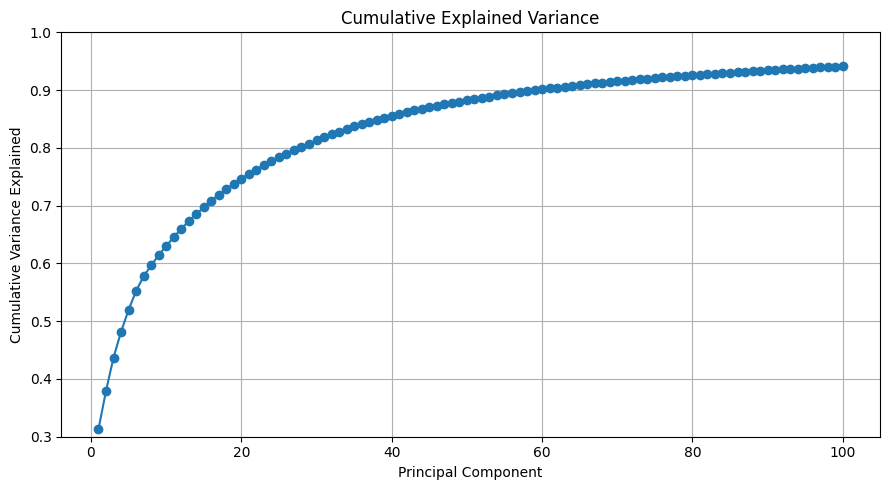

In [31]:
#define data & train/test split
X = df[df.columns[1:-7]]
Y = df[df.columns[-6:]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1203)


#scale data
scaler = StandardScaler()
#train
X_train_scaled=X_train.copy()
#isolate & skip over binary cols
binary_cols = X_train_scaled.columns[X_train_scaled.nunique() == 2]
cont_cols = X_train_scaled.columns[X_train_scaled.nunique() > 2]
X_train_scaled[cont_cols] = scaler.fit_transform(X_train_scaled[cont_cols])

#test
X_test_scaled=X_test.copy()
#scaler = StandardScaler()
#isolate & skip over binary cols
#binary_cols = X_test_scaled.columns[X_test_scaled.nunique() == 2]
#cont_cols = X_test_scaled.columns[X_test_scaled.nunique() > 2]
X_test_scaled[cont_cols] = scaler.transform(X_test_scaled[cont_cols])


pca = PCA(n_components=100,random_state=1203)
pca_fit = pca.fit(X_train_scaled)

PC_values = np.arange(pca.n_components_) + 1

# cumulative
plt.figure(figsize=(9,5))
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.ylim(0.3,1)
plt.tight_layout()
plt.show()

Last ~40 principal components account for less than 5% of explained variance

Use ~75 (similar # yielded from RFs)?

In [32]:
pd.DataFrame(list(np.cumsum(pca.explained_variance_ratio_)),columns=["Cumulative_Var"]).to_csv("PCA_screedata.csv")

In [33]:
df_PCA = pd.DataFrame(list(np.cumsum(pca.explained_variance_ratio_)),columns=["Cumulative_Var"])
df_PCA.iloc[60:]

,Cumulative_Var
60,0.902936
61,0.904488
62,0.905975
63,0.907418
64,0.908833
65,0.910182
66,0.911512
67,0.912819
68,0.914073
69,0.915310


In [63]:
loadings = pca.components_           # shape: (n_components, n_features)
features = X_train_scaled.columns

max_contributors100 = features[np.argmax(np.abs(loadings), axis=1)]
max_contributors75 = features[np.argmax(np.abs(loadings[:75]), axis=1)]

In [64]:
max_contributors100 = list(max_contributors100.unique())
max_contributors75 = list(max_contributors75.unique())
max_contributors100

['HeavyAtomMolWt',
 'MolLogP',
 'NumAromaticRings',
 'SlogP_VSA11',
 'fr_COO2',
 'fr_bicyclic',
 'fr_Ar_NH',
 'fr_priamide',
 'PEOE_VSA14',
 'FpDensityMorgan3',
 'fr_unbrch_alkane',
 'fr_halogen',
 'VSA_EState10',
 'fr_NH2',
 'SlogP_VSA10',
 'fr_lactone',
 'fr_Ndealkylation2',
 'fr_ketone',
 'MinAbsEStateIndex',
 'SlogP_VSA7',
 'EState_VSA7',
 'fr_epoxide',
 'fr_SH',
 'fr_piperdine',
 'Kappa3',
 'SMR_VSA2',
 'PEOE_VSA5',
 'fr_aryl_methyl',
 'fr_urea',
 'EState_VSA6',
 'PEOE_VSA13',
 'PEOE_VSA9',
 'fr_para_hydroxylation',
 'FractionCSP3',
 'fr_alkyl_halide',
 'EState_VSA3',
 'PEOE_VSA4',
 'SlogP_VSA8',
 'PEOE_VSA8',
 'SMR_VSA6',
 'F506',
 'BalabanJ',
 'M81',
 'qed',
 'PEOE_VSA11',
 'EState_VSA9',
 'fr_sulfide',
 'M338',
 'fr_Imine',
 'EState_VSA2',
 'M234',
 'M183',
 'M228',
 'M244',
 'fr_phos_ester',
 'fr_methoxy',
 'F281',
 'M34',
 'M129',
 'M493',
 'PEOE_VSA7',
 'fr_ketone_Topliss',
 'M415']

In [65]:
len(max_contributors100),len(max_contributors75)

(63, 49)

In [69]:
common = list()

for col in max_contributors100:
    if col in list(df_top10s.columns.unique()):
        common.append(col)

print(len(common),"\n")
common

16 



['HeavyAtomMolWt',
 'MolLogP',
 'fr_COO2',
 'FpDensityMorgan3',
 'MinAbsEStateIndex',
 'Kappa3',
 'FractionCSP3',
 'BalabanJ',
 'qed',
 'M338',
 'M234',
 'M183',
 'M34',
 'M129',
 'M493',
 'M415']

^^ new columns are being considered

## Modelling

### train/test

In [76]:
metrics_df = pd.read_csv("/content/CC_metrics.csv",index_col=0)
metrics_df

,metrics,CC_RF,CC_DT,CC_KNN,CC_SVM,CC_topRF,CC_topDT,CC_topKNN,CC_topSVM
0,train_jacc,0.837906,0.851404,0.589390,0.494224,0.906298,0.891496,0.564801,0.496631
1,test_jacc,0.436378,0.393510,0.252083,0.419231,0.418109,0.386538,0.324760,0.434615
2,precision,0.611878,0.525508,0.325269,0.473891,0.568360,0.528515,0.342456,0.482938
3,recall,0.532828,0.560606,0.262626,0.445521,0.491525,0.515738,0.314770,0.472155
4,f1,0.533459,0.539986,0.209938,0.438048,0.503232,0.517810,0.248319,0.451492


In [71]:
pca100_cols = max_contributors100.copy()
pca100_cols.insert(0,"CIDs")
pca100_cols.extend(list(df.columns)[-6:])

df_pca100 = df[pca100_cols]
df_pca100.head(100)

,CIDs,HeavyAtomMolWt,MolLogP,NumAromaticRings,SlogP_VSA11,fr_COO2,fr_bicyclic,fr_Ar_NH,fr_priamide,PEOE_VSA14,...,M493,PEOE_VSA7,fr_ketone_Topliss,M415,EC1,EC2,EC3,EC4,EC5,EC6
0,C00009,94.970,-0.9286,0,0.000000,0,0,0,0,7.822697,...,0,0.000000,0,0,1,1,1,1,0,1
1,C00013,173.941,-0.8116,0,0.000000,0,0,0,0,15.645394,...,0,0.000000,0,0,1,1,1,1,0,1
2,C00014,14.007,0.1620,0,0.000000,0,0,0,0,0.000000,...,0,0.000000,0,0,1,1,1,1,0,1
3,C00017,124.055,-2.1033,0,0.000000,1,0,0,0,50.712056,...,0,0.000000,0,0,0,1,1,0,0,0
4,C00022,84.030,-0.3400,0,0.000000,1,0,0,0,5.969305,...,0,0.000000,1,0,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,C00154,939.428,4.1460,2,0.000000,0,1,0,0,23.468091,...,0,6.420822,0,1,1,1,1,0,0,0
96,C00155,126.116,-0.2818,0,0.000000,1,0,0,0,5.969305,...,0,12.173675,0,0,0,1,0,1,0,0
97,C00156,132.074,1.0904,1,5.749512,1,0,0,0,5.969305,...,0,24.265468,0,0,1,1,0,1,0,1
98,C00157,293.083,-0.0654,0,0.000000,0,0,0,0,116.431309,...,0,0.000000,0,1,0,1,1,0,0,0


In [72]:
X = df_pca100[list(df_pca100.columns)[1:-6]]
Y = df_pca100[list(df_pca100.columns)[-6:]]
X

,HeavyAtomMolWt,MolLogP,NumAromaticRings,SlogP_VSA11,fr_COO2,fr_bicyclic,fr_Ar_NH,fr_priamide,PEOE_VSA14,FpDensityMorgan3,...,M244,fr_phos_ester,fr_methoxy,F281,M34,M129,M493,PEOE_VSA7,fr_ketone_Topliss,M415
0,94.970,-0.9286,0,0.000000,0,0,0,0,7.822697,1.200000,...,0,0,0,0,0,0,0,0.000000,0,0
1,173.941,-0.8116,0,0.000000,0,0,0,0,15.645394,1.111111,...,0,0,0,0,0,0,0,0.000000,0,0
2,14.007,0.1620,0,0.000000,0,0,0,0,0.000000,1.000000,...,0,0,0,0,0,0,0,0.000000,0,0
3,124.055,-2.1033,0,0.000000,1,0,0,0,50.712056,2.666667,...,0,0,0,0,0,1,0,0.000000,0,0
4,84.030,-0.3400,0,0.000000,1,0,0,0,5.969305,1.666667,...,0,0,0,0,1,0,0,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,14.007,-0.5906,0,0.000000,0,0,0,0,6.150546,3.000000,...,0,0,0,0,0,0,0,0.000000,0,0
1035,382.274,2.1668,2,0.000000,0,5,1,0,0.000000,2.800000,...,0,0,0,1,1,0,0,29.541651,0,1
1036,794.397,-3.2261,3,34.497071,0,0,0,0,17.907916,1.389831,...,0,0,0,0,0,1,1,41.961654,0,1
1037,946.458,-5.7112,3,34.497071,0,0,0,0,17.907916,1.171429,...,0,0,0,0,0,1,1,47.525105,0,1


In [73]:
Y

,EC1,EC2,EC3,EC4,EC5,EC6
0,1,1,1,1,0,1
1,1,1,1,1,0,1
2,1,1,1,1,0,1
3,0,1,1,0,0,0
4,1,1,1,1,0,1
...,...,...,...,...,...,...
1034,0,1,0,0,0,1
1035,0,1,0,0,0,0
1036,0,1,0,0,0,0
1037,0,1,1,0,0,0


In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1203)

### RF

In [77]:
base_rf = RandomForestClassifier(max_depth=10, random_state=1203)
chain = ClassifierChain(base_rf, order='random', random_state=1203)

y_pred=chain.fit(X_train, Y_train).predict(X_test)
y_prob=chain.predict_proba(X_test)


# Predictions
Y_pred_train = chain.predict(X_train)
#Y_pred_test = chain.predict(X_test)

# Jaccard Score
train_jaccard = jaccard_score(Y_train, Y_pred_train, average="samples")
test_jaccard = jaccard_score(Y_test, y_pred, average="samples")

print(f"Train Jaccard: {train_jaccard}")
print(f"Test Jaccard:  {test_jaccard}\n")

print(classification_report(Y_test,y_pred),"\n\n")

metrics_df["CC_pcaRF"] = [train_jaccard, test_jaccard, #jaccard score
                    precision_score(Y_test, y_pred,average="weighted"), #'precision'
                    recall_score(Y_test, y_pred,average="weighted"), #'recall'
                    f1_score(Y_test, y_pred,average="weighted")]

metrics_df

Train Jaccard: 0.8616125150421179
Test Jaccard:  0.4327724358974358

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       118
           1       0.64      0.68      0.66       131
           2       0.67      0.30      0.42        66
           3       0.36      0.13      0.19        39
           4       0.25      0.07      0.11        28
           5       0.50      0.10      0.16        31

   micro avg       0.62      0.50      0.56       413
   macro avg       0.51      0.34      0.37       413
weighted avg       0.58      0.50      0.51       413
 samples avg       0.62      0.52      0.52       413
 




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,metrics,CC_RF,CC_DT,CC_KNN,CC_SVM,CC_topRF,CC_topDT,CC_topKNN,CC_topSVM,CC_pcaRF
0,train_jacc,0.837906,0.851404,0.589390,0.494224,0.906298,0.891496,0.564801,0.496631,0.861613
1,test_jacc,0.436378,0.393510,0.252083,0.419231,0.418109,0.386538,0.324760,0.434615,0.432772
2,precision,0.611878,0.525508,0.325269,0.473891,0.568360,0.528515,0.342456,0.482938,0.584745
3,recall,0.532828,0.560606,0.262626,0.445521,0.491525,0.515738,0.314770,0.472155,0.503632
4,f1,0.533459,0.539986,0.209938,0.438048,0.503232,0.517810,0.248319,0.451492,0.513464


### DT

In [78]:
base_rf = DecisionTreeClassifier(max_depth=12, random_state=1203)
chain = ClassifierChain(base_rf, order='random', random_state=1203)

y_pred=chain.fit(X_train, Y_train).predict(X_test)
y_prob=chain.predict_proba(X_test)


# Predictions
Y_pred_train = chain.predict(X_train)
#Y_pred_test = chain.predict(X_test)

# Jaccard Score
train_jaccard = jaccard_score(Y_train, Y_pred_train, average="samples")
test_jaccard = jaccard_score(Y_test, y_pred, average="samples")

print(f"Train Jaccard: {train_jaccard}")
print(f"Test Jaccard:  {test_jaccard}\n")

print(classification_report(Y_test,y_pred),"\n\n")

metrics_df["CC_pcaDT"] = [train_jaccard, test_jaccard,
                    precision_score(Y_test, y_pred,average="weighted"), #'precision'
                    recall_score(Y_test, y_pred,average="weighted"), #'recall'
                    f1_score(Y_test, y_pred,average="weighted")]

metrics_df

Train Jaccard: 0.8502005615724028
Test Jaccard:  0.396474358974359

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       118
           1       0.68      0.61      0.64       131
           2       0.42      0.33      0.37        66
           3       0.28      0.31      0.29        39
           4       0.26      0.29      0.27        28
           5       0.22      0.13      0.16        31

   micro avg       0.53      0.49      0.51       413
   macro avg       0.42      0.39      0.40       413
weighted avg       0.53      0.49      0.50       413
 samples avg       0.56      0.51      0.49       413
 




,metrics,CC_RF,CC_DT,CC_KNN,CC_SVM,CC_topRF,CC_topDT,CC_topKNN,CC_topSVM,CC_pcaRF,CC_pcaDT
0,train_jacc,0.837906,0.851404,0.589390,0.494224,0.906298,0.891496,0.564801,0.496631,0.861613,0.850201
1,test_jacc,0.436378,0.393510,0.252083,0.419231,0.418109,0.386538,0.324760,0.434615,0.432772,0.396474
2,precision,0.611878,0.525508,0.325269,0.473891,0.568360,0.528515,0.342456,0.482938,0.584745,0.525657
3,recall,0.532828,0.560606,0.262626,0.445521,0.491525,0.515738,0.314770,0.472155,0.503632,0.489104
4,f1,0.533459,0.539986,0.209938,0.438048,0.503232,0.517810,0.248319,0.451492,0.513464,0.504928


### KNN

#### standardize data

- better for KNN & SVM

In [79]:
scaler = StandardScaler()

#train
X_train_scaled=X_train.copy()

#isolate & skip over binary cols
binary_cols = X_train_scaled.columns[X_train_scaled.nunique() == 2]
cont_cols = X_train_scaled.columns[X_train_scaled.nunique() > 2]

X_train_scaled[cont_cols] = scaler.fit_transform(X_train_scaled[cont_cols])


#test
X_test_scaled=X_test.copy()

#isolate & skip over binary cols
#binary_cols = X_test_scaled.columns[X_test_scaled.nunique() == 2]
#cont_cols = X_test_scaled.columns[X_test_scaled.nunique() > 2]

X_test_scaled[cont_cols] = scaler.transform(X_test_scaled[cont_cols])

In [80]:
base_rf = KNeighborsClassifier(n_neighbors=5)
chain = ClassifierChain(base_rf, order='random', random_state=1203)

y_pred=chain.fit(X_train_scaled, Y_train).predict(X_test)
y_prob=chain.predict_proba(X_test_scaled)


# Predictions
Y_pred_train = chain.predict(X_train_scaled)
#Y_pred_test = chain.predict(X_test)

# Jaccard Score
train_jaccard = jaccard_score(Y_train, Y_pred_train, average="samples")
test_jaccard = jaccard_score(Y_test, y_pred, average="samples")

print(f"Train Jaccard: {train_jaccard}")
print(f"Test Jaccard:  {test_jaccard}\n")

print(classification_report(Y_test,y_pred),"\n\n")

metrics_df["CC_pcaKNN"] = [train_jaccard, test_jaccard,
                    precision_score(Y_test, y_pred,average="weighted"), #'precision'
                    recall_score(Y_test, y_pred,average="weighted"), #'recall'
                    f1_score(Y_test, y_pred,average="weighted")]

metrics_df

Train Jaccard: 0.5550340954673085
Test Jaccard:  0.18493589743589745

              precision    recall  f1-score   support

           0       0.50      0.01      0.02       118
           1       0.65      0.60      0.62       131
           2       0.50      0.02      0.03        66
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        28
           5       0.00      0.00      0.00        31

   micro avg       0.64      0.20      0.30       413
   macro avg       0.27      0.10      0.11       413
weighted avg       0.43      0.20      0.21       413
 samples avg       0.38      0.19      0.24       413
 




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,metrics,CC_RF,CC_DT,CC_KNN,CC_SVM,CC_topRF,CC_topDT,CC_topKNN,CC_topSVM,CC_pcaRF,CC_pcaDT,CC_pcaKNN
0,train_jacc,0.837906,0.851404,0.589390,0.494224,0.906298,0.891496,0.564801,0.496631,0.861613,0.850201,0.555034
1,test_jacc,0.436378,0.393510,0.252083,0.419231,0.418109,0.386538,0.324760,0.434615,0.432772,0.396474,0.184936
2,precision,0.611878,0.525508,0.325269,0.473891,0.568360,0.528515,0.342456,0.482938,0.584745,0.525657,0.428155
3,recall,0.532828,0.560606,0.262626,0.445521,0.491525,0.515738,0.314770,0.472155,0.503632,0.489104,0.196126
4,f1,0.533459,0.539986,0.209938,0.438048,0.503232,0.517810,0.248319,0.451492,0.513464,0.504928,0.207550


### SVM

In [81]:
base_rf = SVC(random_state=1203)
chain = ClassifierChain(base_rf, order='random', random_state=1203)

y_pred=chain.fit(X_train_scaled, Y_train).predict(X_test_scaled)
#y_prob=chain.predict_proba(X_test)


# Predictions
Y_pred_train = chain.predict(X_train_scaled)
#Y_pred_test = chain.predict(X_test)

# Jaccard Score
train_jaccard = jaccard_score(Y_train, Y_pred_train, average="samples")
test_jaccard = jaccard_score(Y_test, y_pred, average="samples")

print(f"Train Jaccard: {train_jaccard}")
print(f"Test Jaccard:  {test_jaccard}\n")

print(classification_report(Y_test,y_pred),"\n\n")

metrics_df["CC_pcaSVM"] = [train_jaccard, test_jaccard,
                    precision_score(Y_test, y_pred,average="weighted"), #'precision'
                    recall_score(Y_test, y_pred,average="weighted"), #'recall'
                    f1_score(Y_test, y_pred,average="weighted")]

metrics_df

Train Jaccard: 0.5315884476534296
Test Jaccard:  0.4181891025641025

              precision    recall  f1-score   support

           0       0.64      0.76      0.70       118
           1       0.64      0.77      0.70       131
           2       0.43      0.09      0.15        66
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        28
           5       0.00      0.00      0.00        31

   micro avg       0.63      0.48      0.54       413
   macro avg       0.29      0.27      0.26       413
weighted avg       0.45      0.48      0.45       413
 samples avg       0.62      0.50      0.51       413
 




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,metrics,CC_RF,CC_DT,CC_KNN,CC_SVM,CC_topRF,CC_topDT,CC_topKNN,CC_topSVM,CC_pcaRF,CC_pcaDT,CC_pcaKNN,CC_pcaSVM
0,train_jacc,0.837906,0.851404,0.589390,0.494224,0.906298,0.891496,0.564801,0.496631,0.861613,0.850201,0.555034,0.531588
1,test_jacc,0.436378,0.393510,0.252083,0.419231,0.418109,0.386538,0.324760,0.434615,0.432772,0.396474,0.184936,0.418189
2,precision,0.611878,0.525508,0.325269,0.473891,0.568360,0.528515,0.342456,0.482938,0.584745,0.525657,0.428155,0.454923
3,recall,0.532828,0.560606,0.262626,0.445521,0.491525,0.515738,0.314770,0.472155,0.503632,0.489104,0.196126,0.476998
4,f1,0.533459,0.539986,0.209938,0.438048,0.503232,0.517810,0.248319,0.451492,0.513464,0.504928,0.207550,0.445011


KNN & SVM cannot predict EC4-EC6

* drop

DT has most consistent precision vs recall

KNN likely "least overfit" and is underfitting instead because of a maximum potential limit (at least with these hyperparameters)

In [82]:
metrics_df.to_csv("CC_metrics.csv")

In [83]:
metrics_df.T

,0,1,2,3,4
metrics,train_jacc,test_jacc,precision,recall,f1
CC_RF,0.837906,0.436378,0.611878,0.532828,0.533459
CC_DT,0.851404,0.39351,0.525508,0.560606,0.539986
CC_KNN,0.58939,0.252083,0.325269,0.262626,0.209938
CC_SVM,0.494224,0.419231,0.473891,0.445521,0.438048
CC_topRF,0.906298,0.418109,0.56836,0.491525,0.503232
CC_topDT,0.891496,0.386538,0.528515,0.515738,0.51781
CC_topKNN,0.564801,0.32476,0.342456,0.31477,0.248319
CC_topSVM,0.496631,0.434615,0.482938,0.472155,0.451492
CC_pcaRF,0.861613,0.432772,0.584745,0.503632,0.513464
